In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
import random


spark = SparkSession.builder.appName("SentimentAnalysis").master("local[4]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

### Build Model

#### Data inspection

In [8]:
raw_data = spark.read.csv("./training.1600000.processed.noemoticon.csv") \
    .drop("_c1", "_c2", "_c3", "_c4") \
    .toDF("tag", "text")
raw_test_data = spark.read.csv("./testdata.manual.2009.06.14.csv") \
    .drop("_c1", "_c2", "_c3", "_c4") \
    .toDF("tag", "text")

In [9]:
raw_data.describe().show()

+-------+-----------------+--------------------+
|summary|              tag|                text|
+-------+-----------------+--------------------+
|  count|          1600000|             1600000|
|   mean|              2.0|                null|
| stddev|2.000000625000293|                null|
|    min|                0|                 ...|
|    max|                4|�����ߧ�ǿ�����ж�؜�...|
+-------+-----------------+--------------------+



In [5]:
raw_test_data.describe().show()

+-------+------------------+--------------------+
|summary|               tag|                text|
+-------+------------------+--------------------+
|  count|               498|                 498|
|   mean|2.0200803212851404|                null|
| stddev|1.6996858490577658|                null|
|    min|                 0|"""The Republican...|
|    max|                 4|zomg!!! I have a ...|
+-------+------------------+--------------------+



In [4]:
raw_test_data.filter("tag=0").count()

177

In [5]:
raw_test_data.filter("tag=2").count()

139

In [6]:
raw_test_data.filter("tag=4").count()

182

#### Preprocessing

In [10]:
# remove utf-8 unrecognized character 
raw_data = raw_data.filter("text not like '%�%'")
raw_test_data = raw_test_data.filter("text not like '%�%' and tag!=2")
raw_train_data, raw_valid_data = raw_data.randomSplit([0.8, 0.2], seed=24)

In [11]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


'''
    remove html encoding like &amp;
    remove @mention
    remove url link including http, https, www
    remove stopwords
    save only character and '
    to lower case
'''
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern=r'&[a-zA-Z]+;|@[a-zA-Z0-9_]+|https?://[^\s]+|www.[^\s]+.[a-zA-Z]+|[\!\"\#\$\%\&\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^_\`\{\|\}\~\t\n\s]+')
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=2**16)
idf = IDF(inputCol="rawFeatures", outputCol="features")
# tag: 0 negative, 4 positive
# label: 0 negative, 1 positive
indexer = StringIndexer(inputCol="tag", outputCol="label")
pipeline = Pipeline(stages=[regexTokenizer, remover, hashingTF, idf, indexer])

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)

pf = pipeline.fit(raw_train_data)
train_df = pf.transform(raw_train_data)
val_df = pf.transform(raw_valid_data)
test_df = pf.transform(raw_test_data)

# append rawPrediction at the end
lr_model = lr.fit(train_df)
val_pred = lr_model.transform(val_df)

#### Evaluation

In [12]:
valid_metrics = MulticlassMetrics(val_pred.select(val_pred['prediction'], val_pred['label']).rdd)
# Returns confusion matrix: predicted classes are in columns, they are ordered by class label ascending, as in “labels”.
valid_metrics.confusionMatrix().toArray()

array([[118896.,  40848.],
       [ 35139., 123710.]])

In [14]:
test_pred = lr_model.transform(test_df)
test_metrics = MulticlassMetrics(test_pred.select(test_pred['prediction'], test_pred['label']).rdd)
test_metrics.confusionMatrix().toArray()

array([[132.,  45.],
       [ 38., 144.]])

In [22]:
test_metrics.accuracy

0.7688022284122563

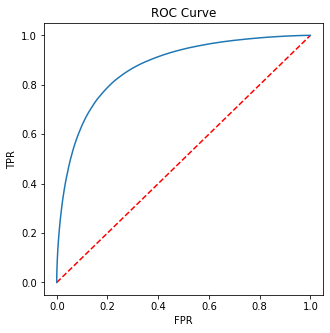

In [21]:
import matplotlib.pyplot as plt


def plot_roc(roc):
    fpr = roc.select('FPR').collect()
    tpr = roc.select('TPR').collect()
    plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.show()
    

plot_roc(lr_model.summary.roc)

In [15]:
full_model = lr.fit(pf.transform(raw_data))
final_pred = full_model.transform(test_df)
final_metrics = MulticlassMetrics(final_pred.select(final_pred['prediction'], final_pred['label']).rdd)
conf_matrix = final_metrics.confusionMatrix().toArray()

In [19]:
conf_matrix

array([[129.,  48.],
       [ 34., 148.]])

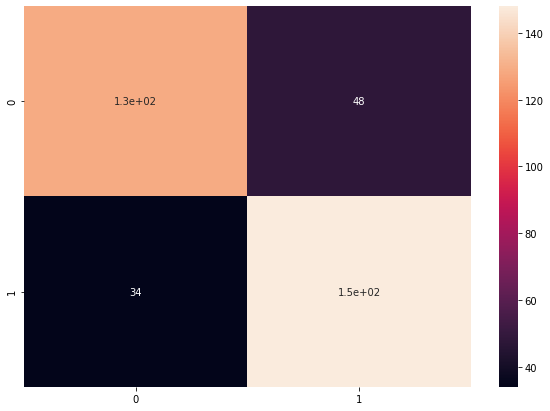

In [18]:
import seaborn as sn


plt.figure(figsize=(10,7))
sn.heatmap(conf_matrix, annot=True)

In [17]:
full_model.save("./sentiment_model")
pf.save("./sentiment_pipeline")

### Streaming process
#### load Model

In [5]:
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LogisticRegressionModel
# from pyspark.mllib.classification import LogisticRegressionModel

pipe_model = PipelineModel.load("./sentiment_pipeline")
lr_model = LogisticRegressionModel.load("./sentiment_model")

In [ ]:
from pyspark.streaming import StreamingContext
from pyspark.sql.types import Row
from queue import Queue
import threading
import json
from functools import reduce
from ipyleaflet import Map, basemaps, Circle
import time


BATCH_INTERVAL = 6
# WINDOWS_LENGTH = 3
# SLIDING_INTERVAL = 3
# FIFO queue, thread safe
CIRCLE_RADIUS = 2
POSITIVE_COLOR = "#EC7063"
NEGATIVE_COLOR = "#2E86C1"
COLORS = [NEGATIVE_COLOR, POSITIVE_COLOR]
pred_que = Queue()
display_que = Queue()

def read_as_json(data):
    try:
        j_data = json.loads(data)
        return j_data
    except json.decoder.JSONDecodeError as e:
        return False

    
def read_coordinates(data):
    '''
        Tweet locations can be an exact ‘point’ location, or a Twitter Place 
        with a ‘bounding box’ that describes a larger area ranging from 
        a venue to an entire region.
        
        Two root-level JSON objects "coordinates", "place".
        If a tweet has been 'geo-tagged', there is always "place".
        "coordinates" exits as [long, lat] array only when the tweet is assigned an exact location.
        "coordinates": {
            "type": "Point",
            "coordinates": []
        }
        "place" object contains "bounding_box", which contains "coordinates" that describe that place.
        "place": {
            "bounding_box": {
                "coordinates": [
                    [
                        [-74.026675,
                          40.683935],
                        ...
                    ]
                ]
            },
        }
        
        Refer to:
        https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/geo-objects

    '''
    try:
        if data.get('coordinates', None):
            # float data, already converetd by json.loads
            return data['coordinates']['coordinates']
        else:
            # it is a ridiculous nested list, therefore [0] is needed
            bounding_box = data['place']['bounding_box']['coordinates'][0]
            # calculate the central point
            return [i/4 for i in reduce(lambda l, r: [l[0]+r[0], l[1]+r[1]], bounding_box)]
    except json.decoder.JSONDecodeError as e:
        print("Read coordinates fails.")
        print(e)
        return [0, 0]

    
def extract_data(data):
    coordinates = read_coordinates(data)
    return [data['text'], coordinates[0], coordinates[1]]
    
    
def print_data(que):
    '''
        Debug function. Output data to sys.stdout.
    '''
    while True:
        l = que.get()
        print(l)

        
def predict(rdd):
    if not rdd.isEmpty():
        df = rdd.map(lambda x: Row(text=x[0], long=x[1], lat=x[2])).toDF()
        pred_que.put(lr_model.transform(pipe_model.transform(df)).select("prediction", "long", "lat").collect(), block=False)


def push_new_points(que, m, li):
    while not que.empty():
        row_list = que.get()
        for row in row_list:
            c = Circle(location=(row.lat, row.long), color=COLORS[int(row.prediction)], fill=True, opacity=0.6, radius=CIRCLE_RADIUS)
            li.append(c)
            m.add_layer(c)
    
    
def pop_points(li, m):
    for c in li:
        m.remove_layer(c)
    li.clear()
    
    
def plot_map(pred_que, display_que):
    m = Map(center=(0,0), zoom=1, dragging=False)
    display(m)
    time.sleep(BATCH_INTERVAL)
    circle_list = []
    while True:
        if not pred_que.empty():
            pop_points(circle_list, m)
            
            s = pred_que.qsize()
            for i in range(s):
                display_que.put(pred_que.get_nowait())
            
            if not display_que.empty():
                push_new_points(display_que, m, circle_list)
            
            time.sleep(BATCH_INTERVAL/2)
        

t = threading.Thread(target=plot_map, args=(pred_que, display_que))
t.start()


ssc = StreamingContext(spark.sparkContext, BATCH_INTERVAL)
dstream = ssc.socketTextStream("localhost", 9994)
# tweet object
# https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json#extendedtweet
# exmaple response
# https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/post-statuses-update
# geo detail
dstream_tweets = dstream.map(lambda data: read_as_json(data)) \
                        .filter(lambda data: data and "created_at" in data) \
                        .map(lambda data: extract_data(data)) \
                        .foreachRDD(predict)

ssc.start()
ssc.awaitTermination()
t.join()


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …